In [2]:
import matplotlib.pyplot as plt
import argparse
import time
import numpy as np
import mne
import samplerate
import os
from scipy import signal

import spkit as sp


#from brainflow #import BrainFlow

from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds, BrainFlowPresets

In [4]:
ls /dev/tty.*

/dev/tty.Bluetooth-Incoming-Port  /dev/tty.debug-console
/dev/tty.JBLTUNE510BT             /dev/tty.usbserial-D200R174


/opt/anaconda3/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=76846) is multi-threaded, use of forkpty() may lead to deadlocks in the child.


In [ ]:
#"/dev/cu.usbserial-DP04WFWZ"

In [82]:

BoardShim.enable_dev_board_logger()

params = BrainFlowInputParams()
#params.serial_port = "/dev/cu.usbserial-DP04WFWZ"
params.serial_port = "/dev/cu.usbserial-D200R174"
board = BoardShim(BoardIds.CYTON_BOARD.value, params)



In [130]:

board.prepare_session()


[2025-05-14 14:46:49.118] [board_logger] [info] incoming json: {
    "file": "",
    "file_anc": "",
    "file_aux": "",
    "ip_address": "",
    "ip_address_anc": "",
    "ip_address_aux": "",
    "ip_port": 0,
    "ip_port_anc": 0,
    "ip_port_aux": 0,
    "ip_protocol": 0,
    "mac_address": "",
    "master_board": -100,
    "other_info": "",
    "serial_number": "",
    "serial_port": "/dev/cu.usbserial-D200R174",
    "timeout": 0
}
[2025-05-14 14:46:49.118] [board_logger] [trace] Board object created 0
[2025-05-14 14:46:49.118] [board_logger] [info] opening port /dev/cu.usbserial-D200R174
[2025-05-14 14:46:49.627] [board_logger] [trace] port /dev/cu.usbserial-D200R174 is open
[2025-05-14 14:46:50.130] [board_logger] [trace] set port settings
[2025-05-14 14:46:50.130] [board_logger] [info] set_latency_res is: 0
[2025-05-14 14:46:50.131] [board_logger] [debug] sending v to the board
[2025-05-14 14:46:51.154] [board_logger] [debug] sending d to the board


In [132]:
board.start_stream()
time.sleep(30) #duration
board.stop_stream()
data = board.get_board_data()  

[2025-05-14 14:46:53.476] [board_logger] [debug] sending b to the board
[2025-05-14 14:47:23.478] [board_logger] [debug] sending s to the board


In [134]:
filename = f'/Users/laura/Documents/MUSE/HOLS/Eyesclosed-Trial3.csv'



directory = os.path.dirname(filename)
if not os.path.exists(directory):
    os.makedirs(directory)

np.savetxt(filename, data, delimiter=',')

In [136]:
board.release_session()

In [26]:
import pandas as pd
from scipy import signal
import numpy as np

def estimate_snr(signal, fs, signal_band=(1,20), noise_band=(0.5, 40)):
    f, Pxx = welch(signal, fs, nperseg=fs*2)
    signal_power = np.sum(Pxx[(f >= signal_band[0]) & (f <= signal_band[1])])
    total_power = np.sum(Pxx[(f >= noise_band[0]) & (f <= noise_band[1])])
    noise_power = total_power - signal_power
    return 10 * np.log10(signal_power / (noise_power + 1e-10))



def filtering(data, samp_freq):
    notch_freq = 50.0
    quality_factor = 30.0 


    b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, samp_freq)

    
    sos = signal.butter(3, [1, 45], btype='bandpass', fs=samp_freq, output='sos')


    data_filtered = np.copy(data)


    for ii in range(data.shape[0]):
     
        data_filtered[ii, :] = signal.filtfilt(b_notch, a_notch, data_filtered[ii, :])
      
        data_filtered[ii, :] = signal.sosfilt(sos, data_filtered[ii, :])

    return data_filtered


In [18]:
import pandas as pd

In [138]:
data2=pd.read_csv('/Users/laura/Documents/MUSE/HOLS/Eyesclosed-Trial3.csv',delimiter=',',header=None)
#/Users/laura/Documents/MUSE/HOLS/18April-trialactiveflat.csv

In [126]:
samp_freq = 250 
data_filtered = filtering(data2, samp_freq) 
n_samples_to_cut = 5 * samp_freq

data_filtered_cut = data_filtered[:, n_samples_to_cut:]
#times_cut = times[n_samples_to_cut:]
XR_M = sp.eeg.ATAR(data_filtered_cut.copy(),wv='db4', winsize=5*250 , beta=0.1,thr_method=None,theta_a=20,OptMode='elim', verbose=0)

/opt/anaconda3/lib/python3.12/site-packages/spkit/eeg/atar_algorithm.py:507: UserWarning: Make sure the upper and lower bound values (k1,k2) are of same order as signal amplitude. If amplitude of signal is much lower than k2 or even k1, ATAR algorithm will have no affect on signal. For example, k2=100, and/or k1=10 is setting for amplitude in micro-volt (in order of 100s). If provided signal is in volt (1e-6), multiply signal with 1e6 (X*1e6) and then apply ATAR
/opt/anaconda3/lib/python3.12/site-packages/spkit/eeg/atar_algorithm.py:510: UserWarning: Upper bound k2 is set to very high. ATAR might have no impact of signal. Either change amplitude unit of signal by multiplying 1e3, or 1e6, or lower the value of k2 and respectively, k1.  One of the straightforward way to set k2 is k2 = np.std(X).


In [127]:
fp2=XR_M[2,:]
fp1=XR_M[1, :]
samp_freq = 250  # Hz
n_samples = XR_M.shape[1]
times = np.arange(n_samples) / samp_freq

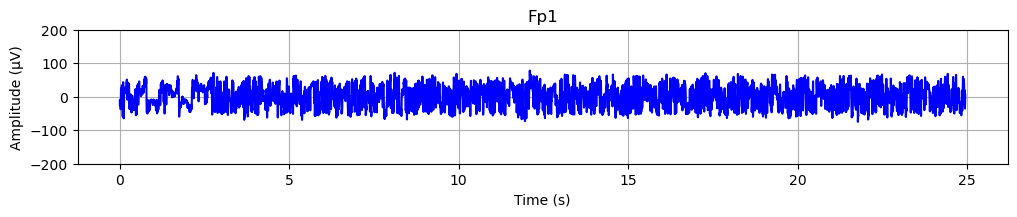

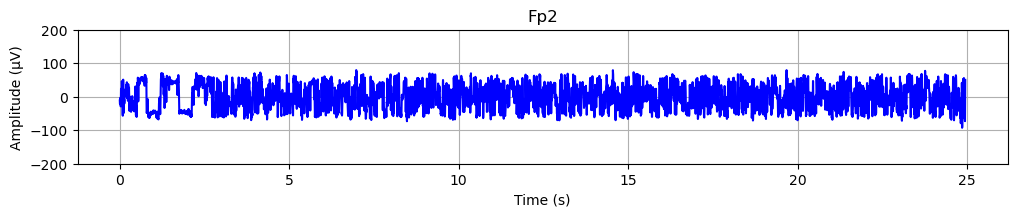

In [112]:
import matplotlib.pyplot as plt


# Crear la figura
plt.figure(figsize=(12, 8))

# Subplot para FP1
plt.subplot(4, 1, 1)
plt.plot(times, fp1, label="Fp1", color='blue')
plt.title("Fp1")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.ylim(-200, 200)
plt.grid(True)

plt.figure(figsize=(12, 8))

# Subplot para FP1
plt.subplot(4, 1, 1)
plt.plot(times, fp2, label="Fp2", color='blue')
plt.title("Fp2")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.ylim(-200, 200)
plt.grid(True)

/opt/anaconda3/lib/python3.12/site-packages/executing/executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
/opt/anaconda3/lib/python3.12/ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead


NameError: name 'fp1' is not defined

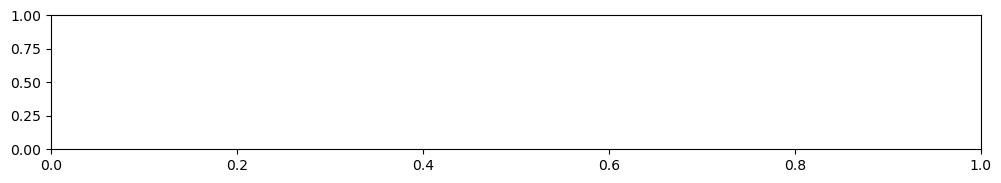

In [50]:
import matplotlib.pyplot as plt


# Crear la figura
plt.figure(figsize=(12, 8))

# Subplot para FP1
plt.subplot(4, 1, 1)
plt.plot(times, fp1, label="Fp1", color='blue')
plt.title("Fp1")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.ylim(-200, 200)
plt.grid(True)

# Subplot para FP2
plt.subplot(4, 1, 2)
plt.plot(times, fp2, label="Fp2", color='red')
plt.title("Fp2")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.ylim(-200, 200)
plt.grid(True)

# Subplot para AF7
plt.subplot(4, 1, 3)
plt.plot(times, af7, label="AF7", color='green')
plt.title("AF7")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.ylim(-200, 200)
plt.grid(True)

# Subplot para AF8
plt.subplot(4, 1, 4)
plt.plot(times, af8, label="AF8", color='purple')
plt.title("AF8")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.ylim(-200, 200)
plt.grid(True)

plt.tight_layout()
plt.show()


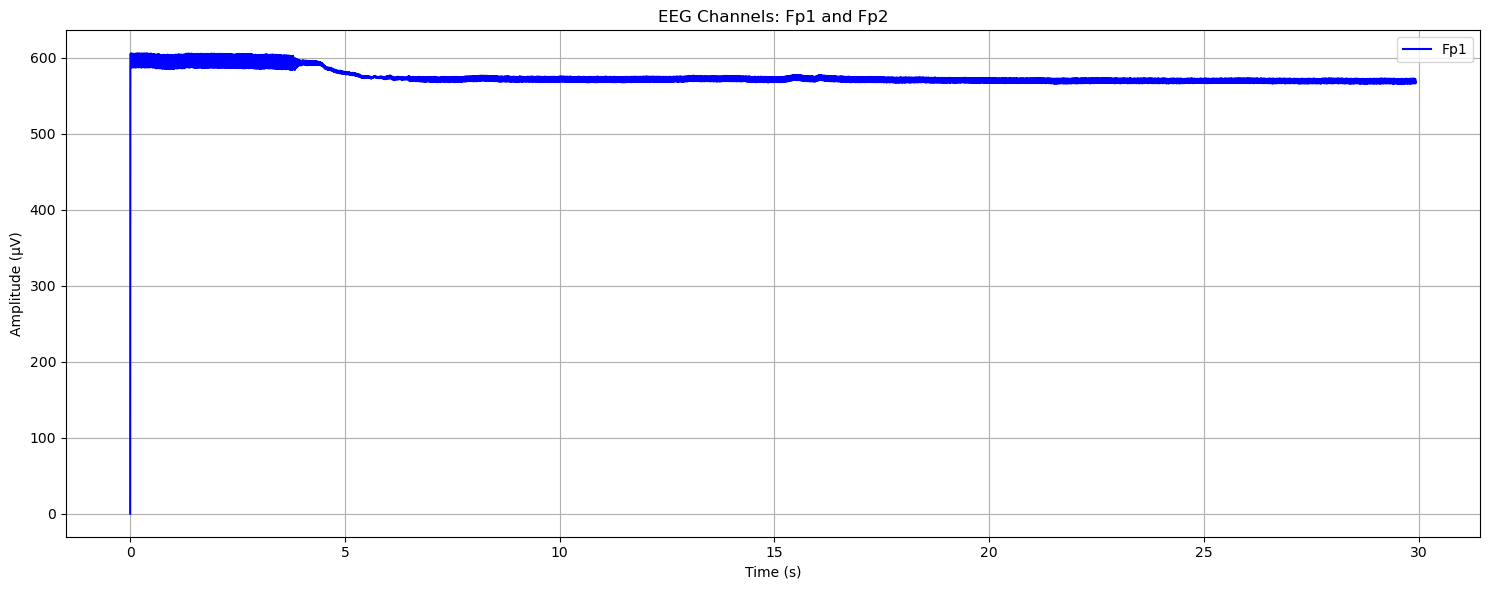

In [54]:
#Active
df=data2
'''4.5 Ref V (ADC range),

2^23 - 1  24 bits ADC,

gain = 24 default gain cyton openbci'''
microvolts_fp1 = fp1 * 0.02235
sampling_rate = 250  # Hz
times = [i / sampling_rate for i in range(len(fp1))]

# Visualización
plt.figure(figsize=(15, 6))
plt.plot(times, microvolts_fp1, label='Fp1', color='blue')
plt.title('EEG Channels: Fp1 and Fp2')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [415]:
def convert_to_microvolts(raw_data, gain=24, vref=4.5, bits=24):
    adc_max = 2**(bits - 1) - 1  # para 24 bits → 2^23 - 1
    scale_factor = (vref / (adc_max * gain)) * 1e6  # en microvoltios
    return raw_data * scale_factor

microvolts = convert_to_microvolts(data2)

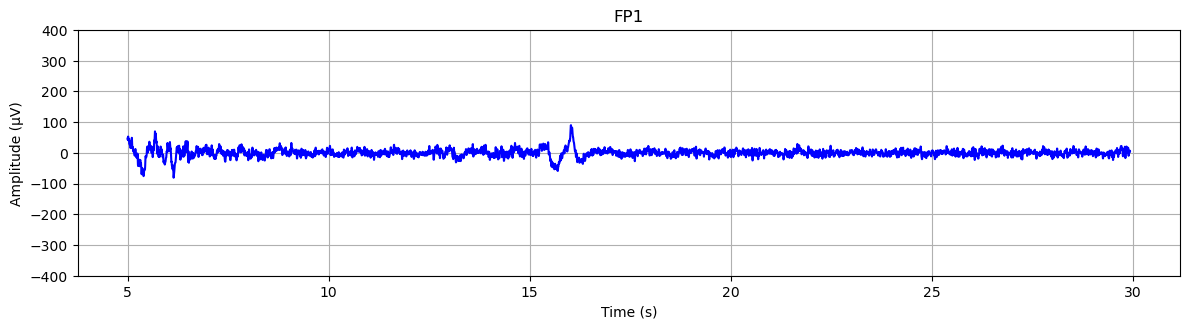

In [56]:
import matplotlib.pyplot as plt
samp_freq = 250 
data_filtered = filtering(data2, samp_freq)
n_samples_to_cut = 5 * samp_freq

data_filtered_cut = data_filtered[:, n_samples_to_cut:]
times_cut = times[n_samples_to_cut:]

plt.figure(figsize=(12, 6))

# Graficar para el canal Fp1
plt.subplot(2, 1, 1)
plt.plot(times_cut, data_filtered_cut[1, :], label="Fp1", color='blue')
plt.title("FP1")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.ylim(-400,400)
plt.grid(True)


plt.tight_layout()
plt.show()


In [58]:
XR_M = sp.eeg.ATAR(data_filtered_cut.copy(),wv='db4', winsize=5*250, beta=0.1,thr_method=None,theta_a=20,OptMode='elim', verbose=0)

/opt/anaconda3/lib/python3.12/site-packages/spkit/eeg/atar_algorithm.py:507: UserWarning: Make sure the upper and lower bound values (k1,k2) are of same order as signal amplitude. If amplitude of signal is much lower than k2 or even k1, ATAR algorithm will have no affect on signal. For example, k2=100, and/or k1=10 is setting for amplitude in micro-volt (in order of 100s). If provided signal is in volt (1e-6), multiply signal with 1e6 (X*1e6) and then apply ATAR
/opt/anaconda3/lib/python3.12/site-packages/spkit/eeg/atar_algorithm.py:510: UserWarning: Upper bound k2 is set to very high. ATAR might have no impact of signal. Either change amplitude unit of signal by multiplying 1e3, or 1e6, or lower the value of k2 and respectively, k1.  One of the straightforward way to set k2 is k2 = np.std(X).


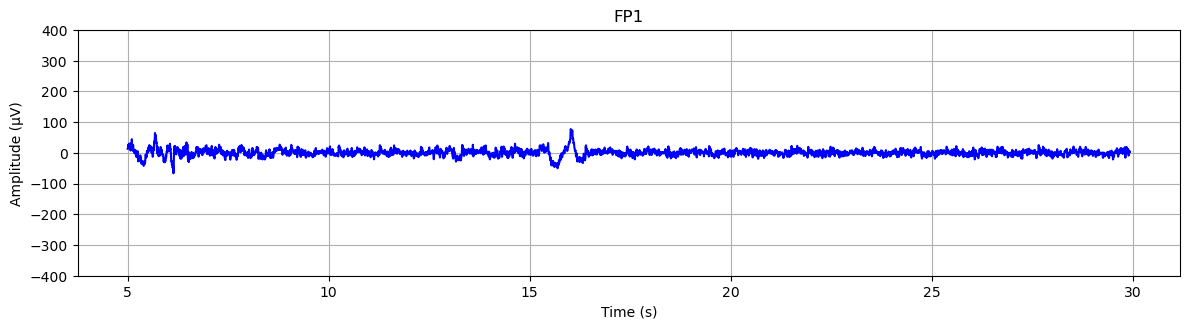

In [60]:


plt.figure(figsize=(12, 6))


plt.subplot(2, 1, 1)
plt.plot(times_cut, XR_M[1, :], label="Fp1", color='blue')
plt.title("FP1")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.ylim(-400,400)
plt.grid(True)


plt.tight_layout()
plt.show()


In [78]:
fp1=XR_M[3, :]

stats_fp1 = basic_stats(fp1)

print(stats_fp1)


snr_fp1 = estimate_snr(fp1, fs)


print(snr_fp1)

NameError: name 'basic_stats' is not defined

In [80]:
fs=250
plot_fft(f, fs, canal=1)  
# IT MAKES SENSE!!

NameError: name 'plot_fft' is not defined

{'mean': 0.3070676231741368, 'std': 41.26533979035388, 'rms': 41.26648226513334, 'peak_to_peak': 182.16647383336698}
-13.49397658320319


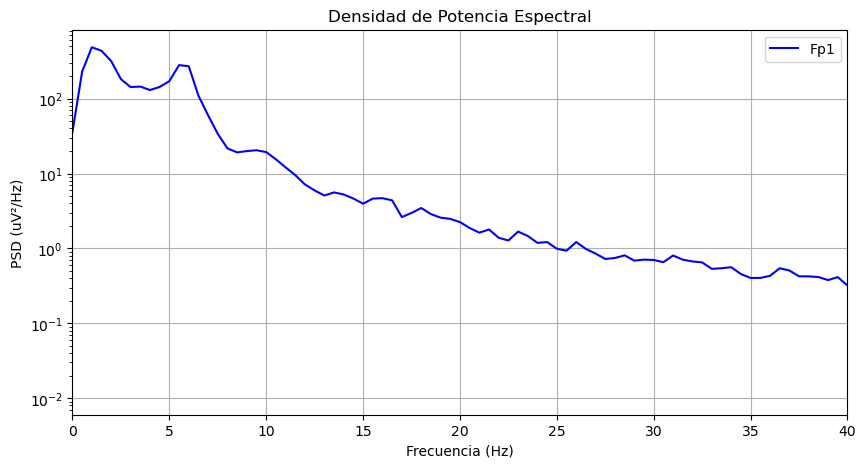

In [423]:
#Checking
fp1=XR_M[1, :]

stats_fp1 = basic_stats(fp1)
print(stats_fp1)
snr_fp1 = estimate_snr(fp1, fs)
print(snr_fp1)

plt.figure(figsize=(10, 5))
f1, Pxx1 = welch(fp1, fs, nperseg=fs*2)

plt.semilogy(f1, Pxx1, label='Fp1', color='blue')
plt.xlabel('FREQ (Hz)')
plt.ylabel('PSD (uV²/Hz)')
plt.legend()
plt.title('PSD')
plt.xlim(0, 40)
plt.grid(True)
plt.show()



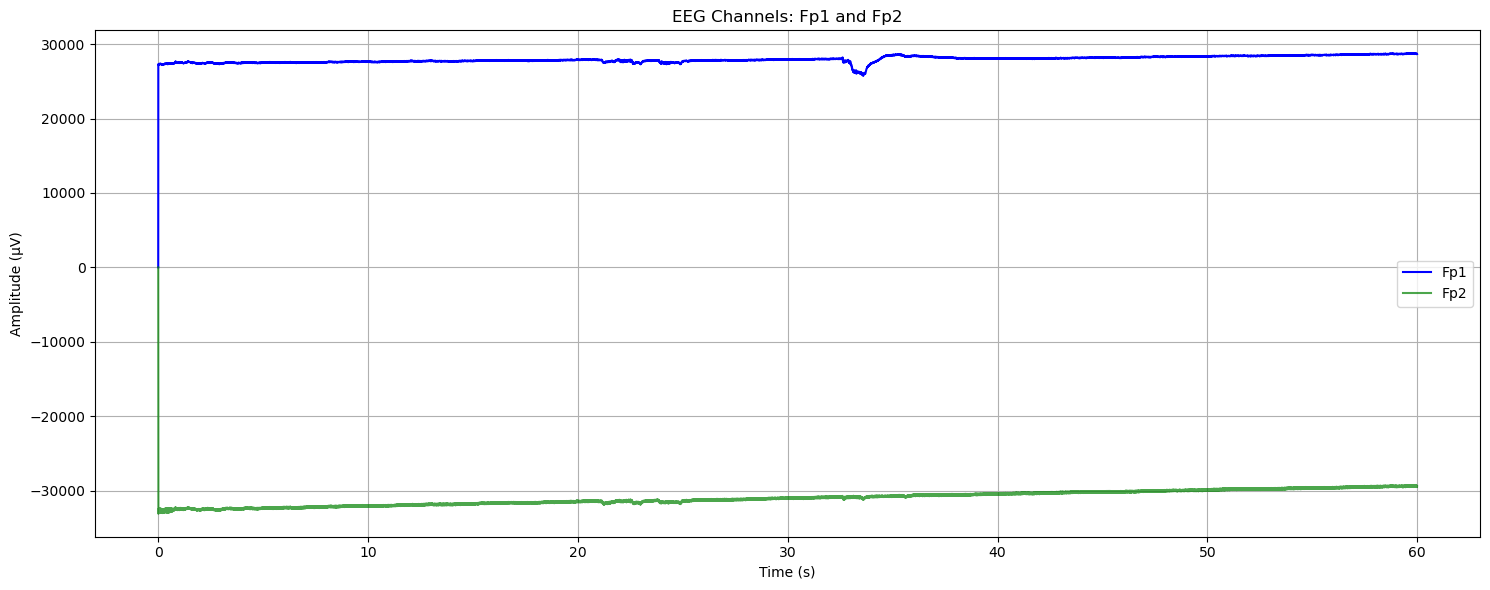

In [254]:
#passive ones
df=data2
fp1 = df.iloc[1]
fp2 = df.iloc[2]


sampling_rate = 250  # Hz
times = [i / sampling_rate for i in range(len(fp1))]

# Visualización
plt.figure(figsize=(15, 6))
plt.plot(times, fp1, label='Fp1', color='blue')
plt.plot(times, fp2, label='Fp2', color='green', alpha=0.7)
plt.title('EEG Channels: Fp1 and Fp2')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

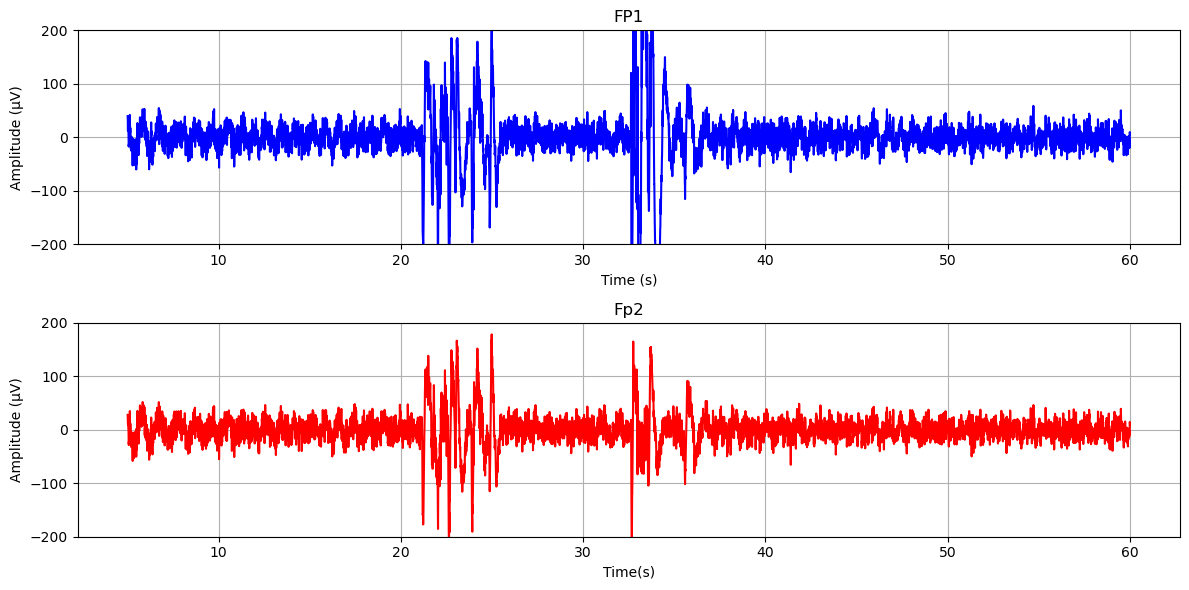

In [264]:
import matplotlib.pyplot as plt
samp_freq = 250 
data_filtered = filtering(data, samp_freq)
n_samples_to_cut = 5 * samp_freq

data_filtered_cut = data_filtered[:, n_samples_to_cut:]
times_cut = times[n_samples_to_cut:]

plt.figure(figsize=(12, 6))

# Fp1
plt.subplot(2, 1, 1)
plt.plot(times_cut, data_filtered_cut[0, :], label="Fp1", color='blue')
plt.title("FP1")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.ylim(-200,200)
plt.grid(True)

#Fp2
plt.subplot(2, 1, 2)
plt.plot(times_cut, data_filtered_cut[1, :], label="Fp2 ", color='red')
plt.title("Fp2")
plt.xlabel("Time(s)")
plt.ylabel("Amplitude (µV)")
plt.ylim(-200,200)
plt.grid(True)


plt.tight_layout()
plt.show()


In [266]:
XR_M = sp.eeg.ATAR(data_filtered_cut.copy(),wv='db4', winsize=5*125, beta=0.1,thr_method=None,theta_a=20,OptMode='elim', verbose=0)

/opt/anaconda3/lib/python3.12/site-packages/spkit/eeg/atar_algorithm.py:507: UserWarning: Make sure the upper and lower bound values (k1,k2) are of same order as signal amplitude. If amplitude of signal is much lower than k2 or even k1, ATAR algorithm will have no affect on signal. For example, k2=100, and/or k1=10 is setting for amplitude in micro-volt (in order of 100s). If provided signal is in volt (1e-6), multiply signal with 1e6 (X*1e6) and then apply ATAR
/opt/anaconda3/lib/python3.12/site-packages/spkit/eeg/atar_algorithm.py:510: UserWarning: Upper bound k2 is set to very high. ATAR might have no impact of signal. Either change amplitude unit of signal by multiplying 1e3, or 1e6, or lower the value of k2 and respectively, k1.  One of the straightforward way to set k2 is k2 = np.std(X).


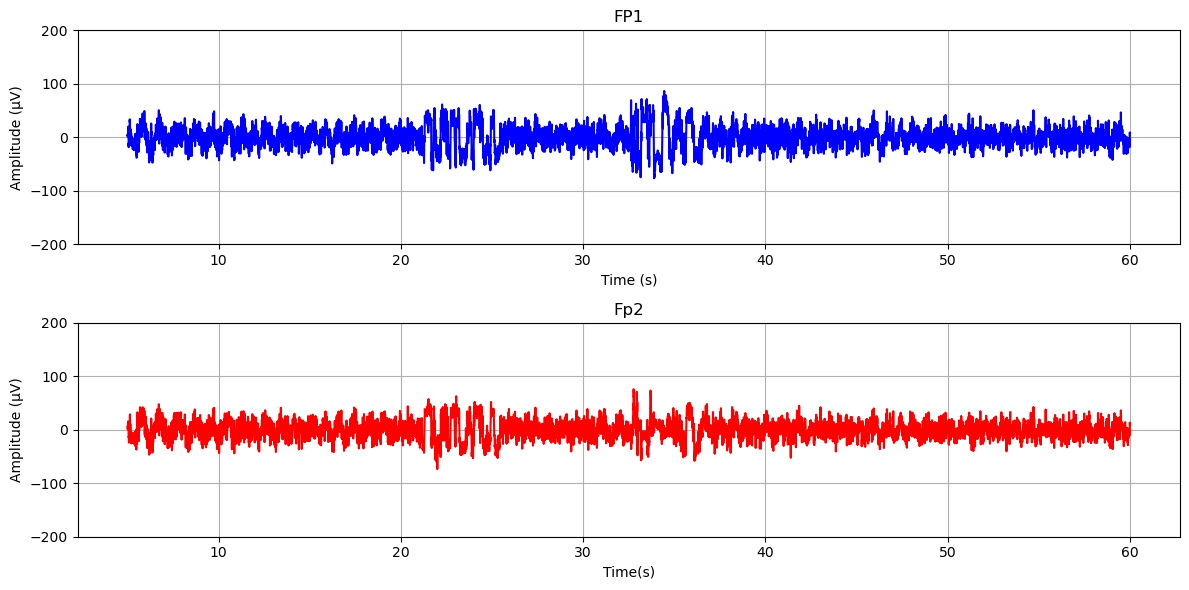

In [268]:
plt.figure(figsize=(12, 6))

#  Fp1
plt.subplot(2, 1, 1)
plt.plot(times_cut, XR_M[0, :], label="Fp1", color='blue')
plt.title("FP1")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.ylim(-200,200)
plt.grid(True)

#  Fp2
plt.subplot(2, 1, 2)
plt.plot(times_cut, XR_M[1, :], label="Fp2 ", color='red')
plt.title("Fp2")
plt.xlabel("Time(s)")
plt.ylabel("Amplitude (µV)")
plt.ylim(-200,200)
plt.grid(True)


plt.tight_layout()
plt.show()

In [288]:
fp1=XR_M[0, :]
fp2=XR_M[1, :]

In [66]:
#Checking
def basic_stats(signal):
    return {
        'mean': np.mean(signal),
        'std': np.std(signal),
        'rms': np.sqrt(np.mean(signal**2)),
        'peak_to_peak': np.ptp(signal)
    }

stats_fp1 = basic_stats(fp1)
stats_fp2 = basic_stats(fp2)
print(stats_fp1)
print(stats_fp2)

{'mean': 0.610677159030872, 'std': 11.077927710019093, 'rms': 11.094746907477019, 'peak_to_peak': 144.15823776899754}
{'mean': -0.3054390991035764, 'std': 8.096401949130206, 'rms': 8.102161289751061, 'peak_to_peak': 87.27108963866154}


Average close to 0, so ideal 
FP2 less noise, better quality but the difference are not huge

In [439]:
#NOISE RATIO

from scipy.signal import welch

def estimate_snr(signal, fs, signal_band=(1,20), noise_band=(0.5, 40)):
    f, Pxx = welch(signal, fs, nperseg=fs*2)
    signal_power = np.sum(Pxx[(f >= signal_band[0]) & (f <= signal_band[1])])
    total_power = np.sum(Pxx[(f >= noise_band[0]) & (f <= noise_band[1])])
    noise_power = total_power - signal_power
    return 10 * np.log10(signal_power / (noise_power + 1e-10))

snr_fp1 = estimate_snr(fp1, fs)
snr_fp2 = estimate_snr(fp2, fs)

print(snr_fp1)
print(snr_fp2)

9.834275567629435
4.958733687315606


FP2 lower snr, better signal quality 

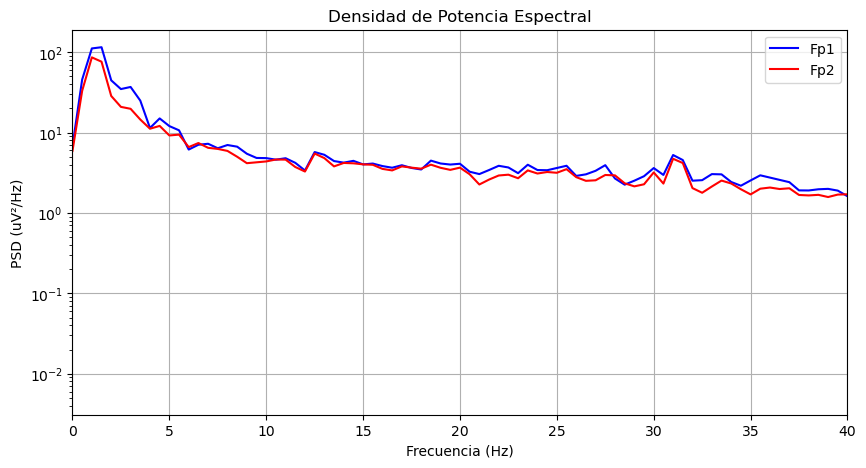

In [294]:
#PSD

plt.figure(figsize=(10, 5))
f1, Pxx1 = welch(fp1, fs, nperseg=fs*2)
f2, Pxx2 = welch(fp2, fs, nperseg=fs*2)

plt.semilogy(f1, Pxx1, label='Fp1', color='blue')
plt.semilogy(f2, Pxx2, label='Fp2', color='red')
plt.xlabel('Freq (Hz)')
plt.ylabel('PSD (uV²/Hz)')
plt.legend()
plt.title('psd')
plt.xlim(0, 40)
plt.grid(True)
plt.show()

In [296]:
correlation = np.corrcoef(fp1, fp2)[0, 1]
print(correlation)
# good sinchrony, simmetry, not pollution among signals 

0.7816104366476792


In [298]:
def quality_score(stats, snr):
    return snr / stats['std']  # penaliza SNR alto con mucha variabilidad

score_fp1 = quality_score(stats_fp1, snr_fp1)
score_fp2 = quality_score(stats_fp2, snr_fp2)

print(score_fp1)
print(score_fp2)


-0.6016032107535191
-0.654163718015596


In [302]:
#function 
import numpy as np
from scipy.signal import welch
from numpy import corrcoef

def basic_stats(signal):
    return {
        'mean': np.mean(signal),
        'std': np.std(signal),
        'rms': np.sqrt(np.mean(signal**2)),
        'peak_to_peak': np.ptp(signal)
    }

def estimate_snr(signal, fs, signal_band=(8, 12), noise_band=(0.5, 40)):
    f, Pxx = welch(signal, fs, nperseg=fs*2)
    signal_power = np.sum(Pxx[(f >= signal_band[0]) & (f <= signal_band[1])])
    total_power = np.sum(Pxx[(f >= noise_band[0]) & (f <= noise_band[1])])
    noise_power = total_power - signal_power
    return 10 * np.log10(signal_power / (noise_power + 1e-10))

def quality_score(snr, std):
    return snr / std

def compare_eeg_channels(ch1, ch2, fs, label1='Ch1', label2='Ch2'):
    stats1 = basic_stats(ch1)
    stats2 = basic_stats(ch2)

    snr1 = estimate_snr(ch1, fs)
    snr2 = estimate_snr(ch2, fs)

    qscore1 = quality_score(snr1, stats1['std'])
    qscore2 = quality_score(snr2, stats2['std'])

    corr = corrcoef(ch1, ch2)[0, 1]

    results = {
        label1: {**stats1, 'snr': snr1, 'quality_score': qscore1},
        label2: {**stats2, 'snr': snr2, 'quality_score': qscore2},
        'correlation': corr
    }

    
    score1 = (snr1 - stats1['std'])  
    score2 = (snr2 - stats2['std'])
    better = label1 if score1 > score2 else label2
    results['verdict'] = f"Best channel : {better}"

    return results
    
results = compare_eeg_channels(fp1, fp2, fs, label1='Fp1', label2='Fp2')
for key, val in results.items():
    print(f"{key}: {val}")


Fp1: {'mean': -0.019767142869325304, 'std': 19.441890129953585, 'rms': 19.441900178869446, 'peak_to_peak': 163.35933839670867, 'snr': -11.696303525297228, 'quality_score': -0.6016032107535191}
Fp2: {'mean': 0.011119395900497892, 'std': 16.92560446915362, 'rms': 16.925608121636227, 'peak_to_peak': 149.47619372305923, 'snr': -11.07211634920292, 'quality_score': -0.654163718015596}
correlation: 0.7816104366476792
verdict: Mejor canal: Fp2


In [365]:
def plot_fft(data, fs, canal=0):
    from scipy.fft import fft, fftfreq

    señal = data[canal]
    n = len(señal)
    freqs = fftfreq(n, d=1/fs)
    magnitud = np.abs(fft(señal))[:n//2]
    freqs = freqs[:n//2]

    plt.figure(figsize=(10, 4))
    plt.plot(freqs, magnitud, color='darkgreen')
    plt.title(f'Espectro de Frecuencia - Canal {canal}')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Magnitud')
    plt.xlim(0, 60)  # para ver hasta 60 Hz
    plt.grid(True)
    plt.tight_layout()
    plt.show()


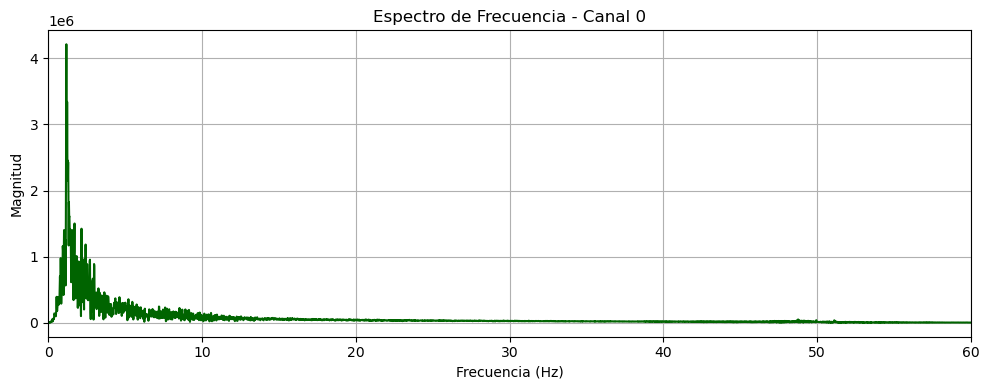

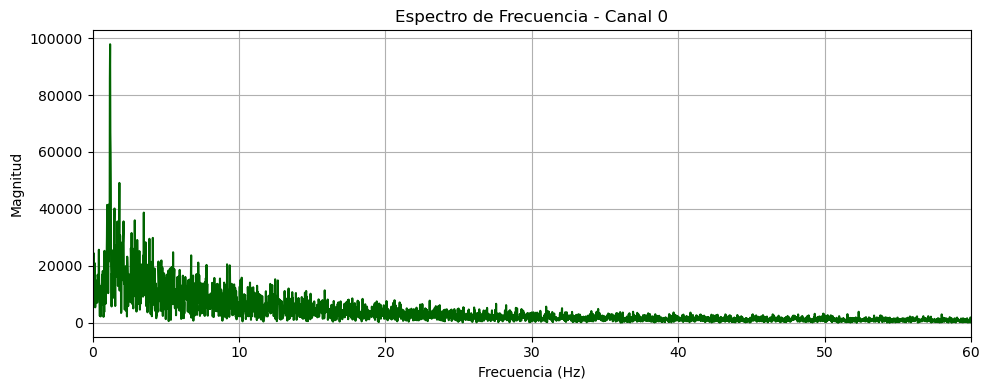

In [198]:
fs=250
plot_fft(eeg_filtered, fs, canal=0)  # Señal sin filtrar
plot_fft(XR_M, fs, canal=0)  # Señal filtrada

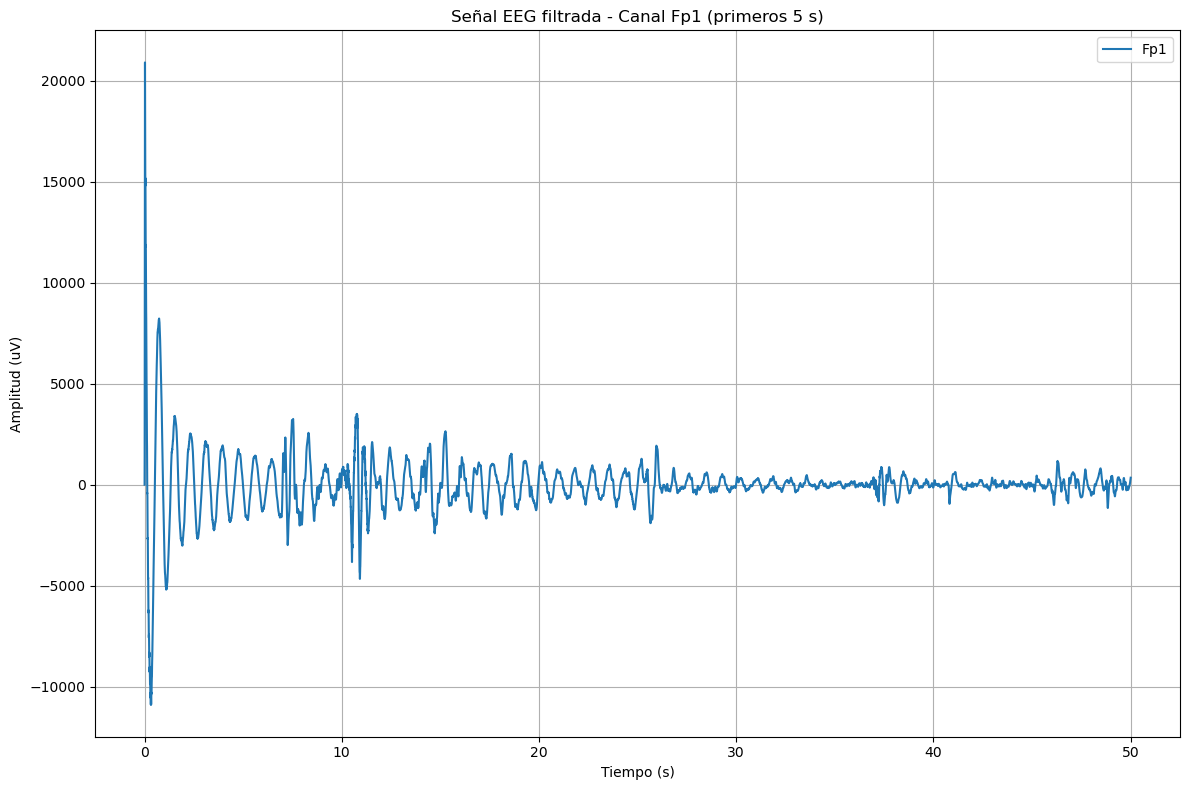

In [192]:
import numpy as np
import matplotlib.pyplot as plt

samp_freq = 250 # Hz
seconds_to_plot = 50
samples_to_plot = samp_freq * seconds_to_plot
eeg_names = ['Fp1', 'Fp2', 'C3', 'C4', 'P7', 'P8', 'O1', 'O2']

t = np.linspace(0, seconds_to_plot, samples_to_plot)

# Canal a seleccionar
canal_seleccionado = 'Fp1'

# Índice del canal
canal_idx = eeg_names.index(canal_seleccionado)

plt.figure(figsize=(12, 8))

# Solo trazamos el canal seleccionado
plt.plot(t, eeg_filtered[0, :samples_to_plot], label=canal_seleccionado)

plt.title(f"Señal EEG filtrada - Canal {canal_seleccionado} (primeros 5 s)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (uV)")



plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

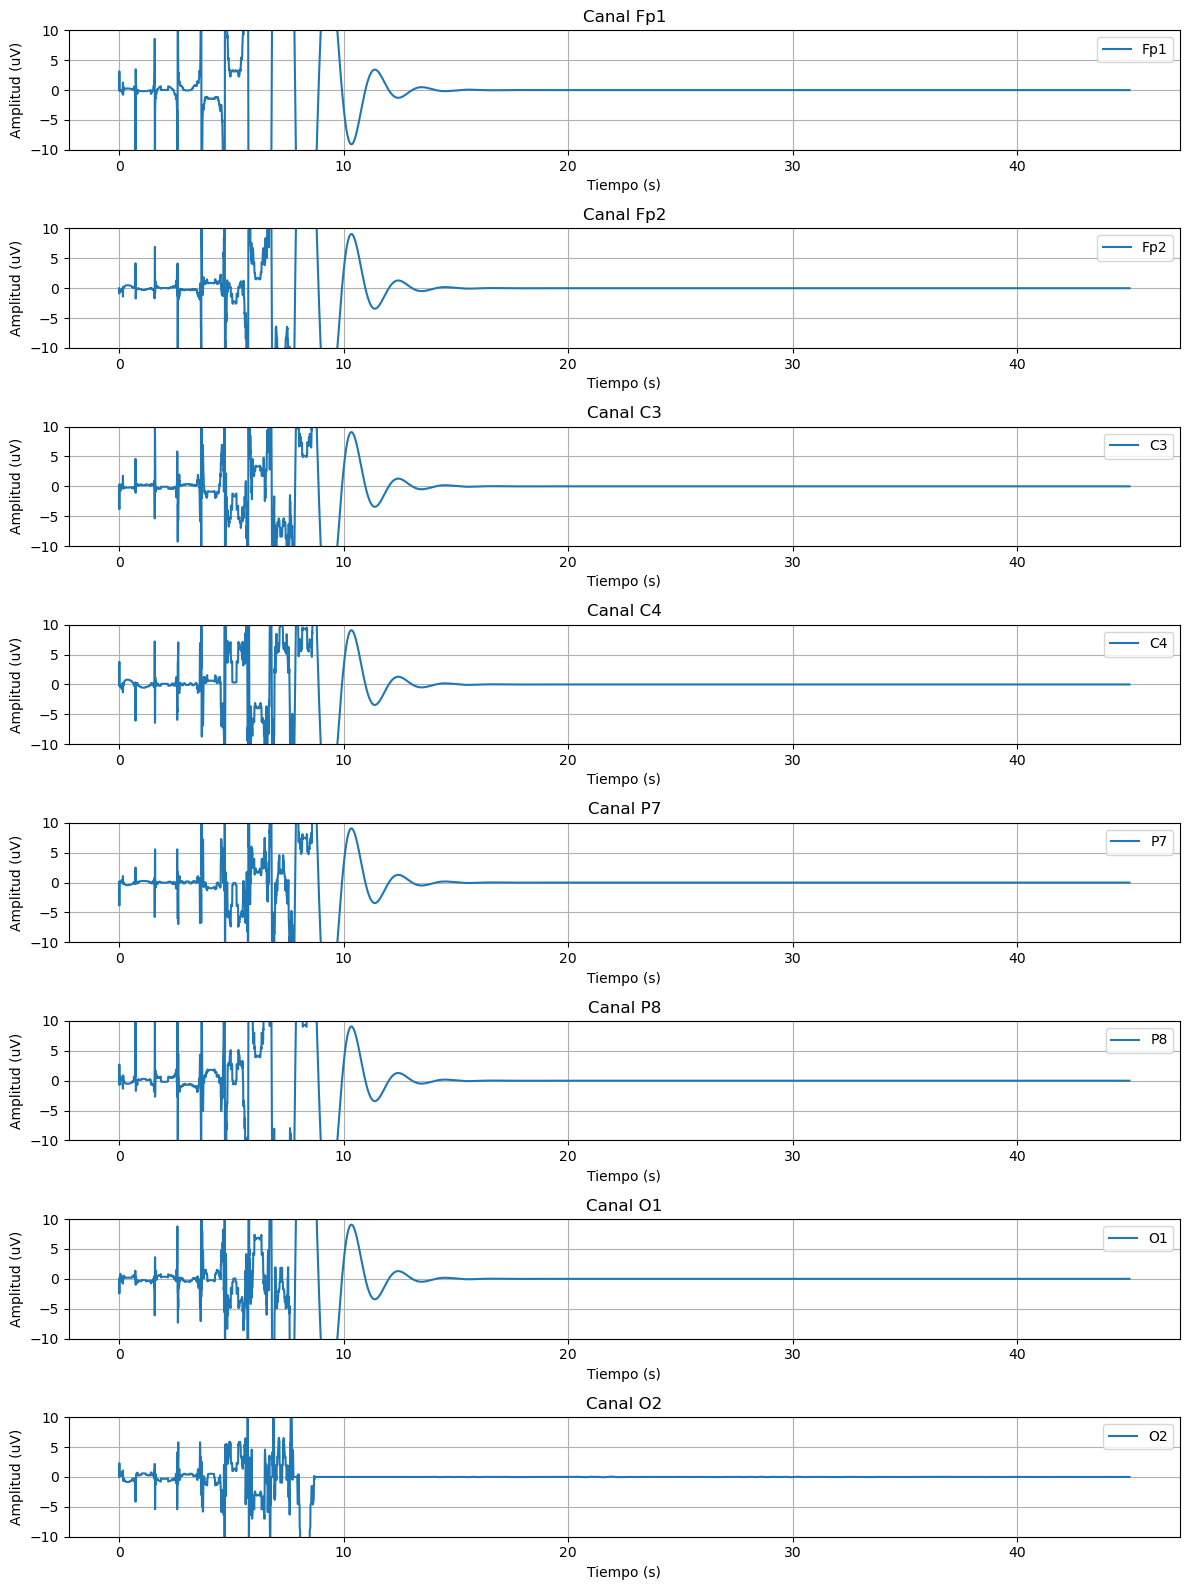

In [112]:
import numpy as np
import matplotlib.pyplot as plt

samp_freq = 125  # Hz
seconds_to_plot = 45
samples_to_plot = samp_freq * seconds_to_plot
eeg_names = ['Fp1', 'Fp2', 'C3', 'C4', 'P7', 'P8', 'O1', 'O2']

t = np.linspace(0, seconds_to_plot, samples_to_plot)

# Crear una figura con subgráficas
fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(12, 16))  # 8 subgráficas (1 para cada canal)

# Trazar cada canal en su respectiva subgráfica
for i in range(len(eeg_names)):
    axes[i].plot(t, XR_M[i, :samples_to_plot], label=eeg_names[i])  # Graficar la señal para cada canal
    axes[i].set_title(f"Canal {eeg_names[i]}")
    axes[i].set_xlabel("Tiempo (s)")
    axes[i].set_ylabel("Amplitud (uV)")
    axes[i].set_ylim(-10, 10)
    axes[i].grid(True)
    axes[i].legend(loc='upper right')

# Ajustar el diseño de las subgráficas
plt.tight_layout()
plt.show()


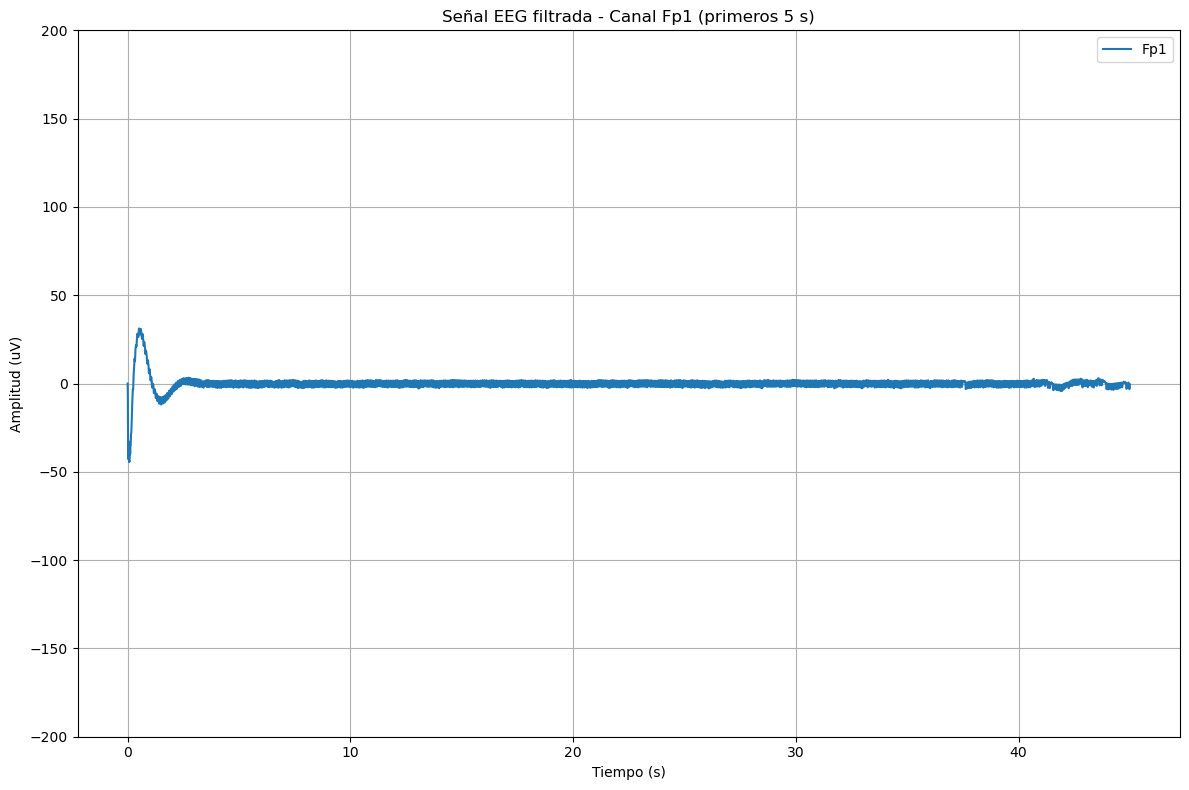

In [49]:
import numpy as np
import matplotlib.pyplot as plt

samp_freq = 125  # Hz
seconds_to_plot = 45
samples_to_plot = samp_freq * seconds_to_plot
eeg_names = ['Fp1', 'Fp2', 'C3', 'C4', 'P7', 'P8', 'O1', 'O2']

t = np.linspace(0, seconds_to_plot, samples_to_plot)


channel = 'Fp1'


canal_idx = eeg_names.index(channel)

plt.figure(figsize=(12, 8))

plt.plot(t, XR_M[canal_idx, :samples_to_plot], label=channel)

plt.title(f"SIGNAL {channel} ( 5 s)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (uV)")
plt.ylim(-200, 200)

plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


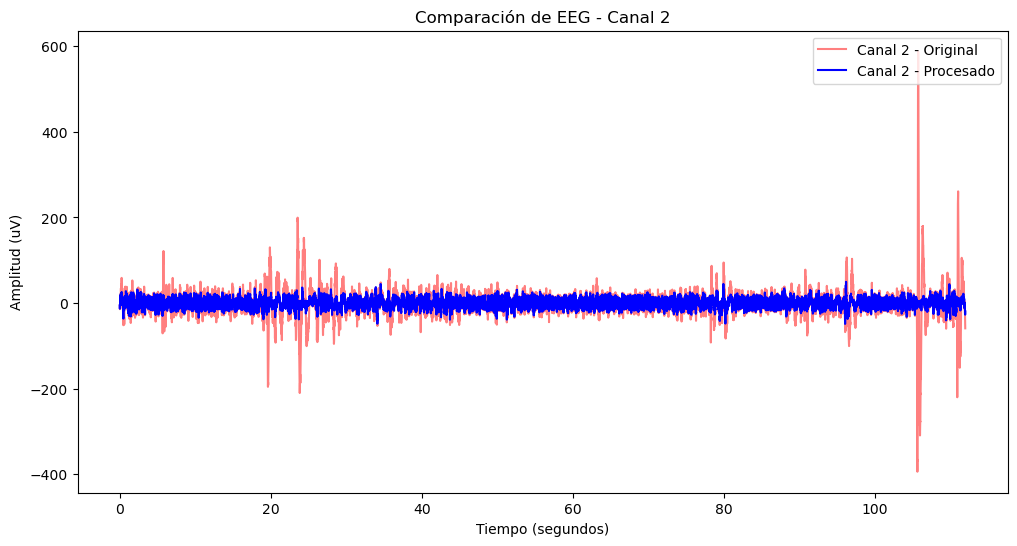

In [154]:
import matplotlib.pyplot as plt
import numpy as np

channel_index = 2 

sampling_rate = 125  
n_samples = data1.shape[1]  
time = np.arange(n_samples) / sampling_rate  

plt.figure(figsize=(12, 6))
plt.plot(time, data1[channel_index, :], label=f'Canal {channel_index} - Original', color='r', alpha=0.5)
plt.plot(time, XR_M[channel_index, :], label=f'Canal {channel_index} - Procesado', color='b')
plt.title(f'Comparison EEG {channel_index}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.legend(loc='upper right')



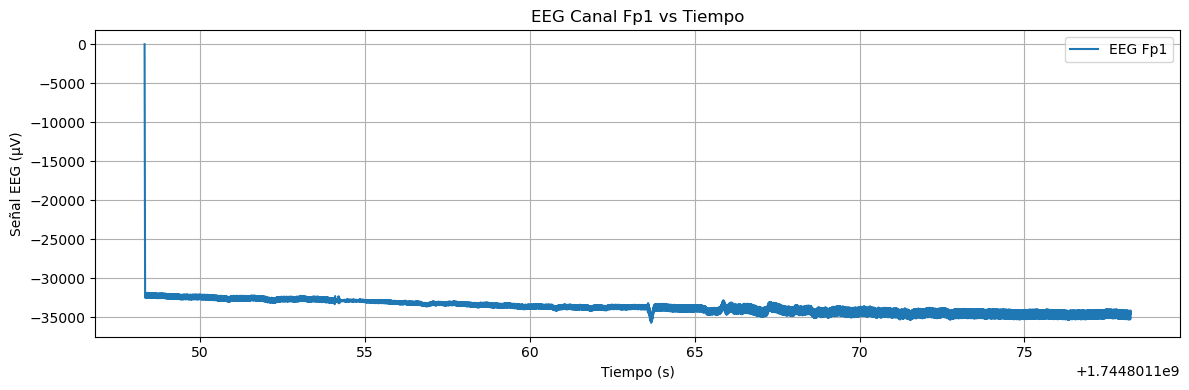

In [114]:

fp1 = pd.to_numeric(data.iloc[0], errors='coerce')      # Fp1 = fila 1

# Graficar
plt.figure(figsize=(12, 4))
plt.plot(timestamps, fp1, label='EEG Fp1')
plt.xlabel('Time (s)')
plt.ylabel('EEG (µV)')
plt.title('EEG vs TIME')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [116]:
fp1

0.000000000000000000e+00           0.000000
1.000000000000000000e+00      -32280.679915
2.000000000000000000e+00      -32482.113836
3.000000000000000000e+00      -32239.463298
4.000000000000000000e+00      -31911.540855
                                   ...     
5.400000000000000000e+01.29   -35205.316270
5.500000000000000000e+01.29   -35231.736032
5.600000000000000000e+01.29   -34574.550042
5.700000000000000000e+01.29   -34137.282865
5.800000000000000000e+01.29   -34544.285780
Name: 0, Length: 7483, dtype: float64

In [122]:
import numpy as np
import scipy.signal as signal
import spkit as sp

def filtering(data, samp_freq, b_ar=0.9):
    
    if data.ndim == 1:
        data = data.reshape(1, -1)  


    notch_freq = 50.0
    quality_factor = 3.0
    b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, samp_freq)

   
    sos = signal.butter(2, [1, 45], btype='bandpass', fs=samp_freq, output='sos')

 
    data_notched = np.copy(data)
    data_bandpassed = np.copy(data)

    for i in range(data.shape[0]):
        data_notched[i, :] = signal.filtfilt(b_notch, a_notch, data[i, :])
        data_bandpassed[i, :] = signal.sosfilt(sos, data_notched[i, :])


    filt = sp.eeg.ATAR(data_bandpassed.copy(), wv='db4', winsize=125 * 5, beta=b_ar,
                       thr_method=None, theta_a=10, OptMode='elim', verbose=0)

   
    filt = filt * 1e-6

 
    return filt.flatten() if filt.shape[0] == 1 else filt


/opt/anaconda3/lib/python3.12/site-packages/spkit/eeg/atar_algorithm.py:507: UserWarning: Make sure the upper and lower bound values (k1,k2) are of same order as signal amplitude. If amplitude of signal is much lower than k2 or even k1, ATAR algorithm will have no affect on signal. For example, k2=100, and/or k1=10 is setting for amplitude in micro-volt (in order of 100s). If provided signal is in volt (1e-6), multiply signal with 1e6 (X*1e6) and then apply ATAR
/opt/anaconda3/lib/python3.12/site-packages/spkit/eeg/atar_algorithm.py:510: UserWarning: Upper bound k2 is set to very high. ATAR might have no impact of signal. Either change amplitude unit of signal by multiplying 1e3, or 1e6, or lower the value of k2 and respectively, k1.  One of the straightforward way to set k2 is k2 = np.std(X).


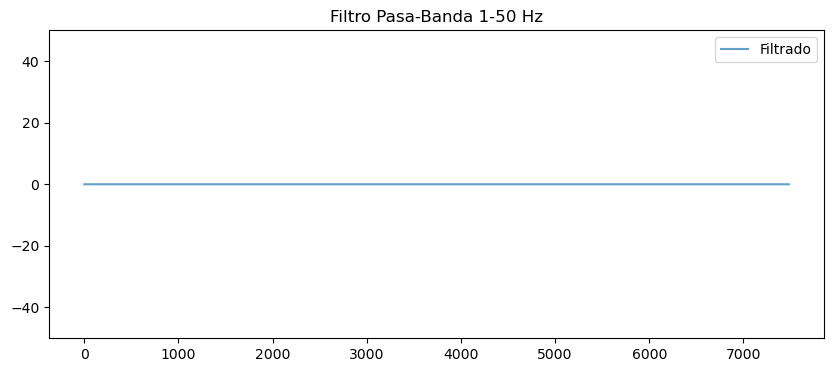

In [128]:

fs = 125  
lowcut = 1.0  
highcut = 45.0  



canal_filtrado = filtering(fp1.values, fs)


plt.figure(figsize=(10, 4))
plt.plot(canal_filtrado, label='Filtered', alpha=0.7)
plt.ylim(-50, 50)  
plt.legend()
plt.title("FILTER BAND PASS  1-50 Hz")
plt.show()


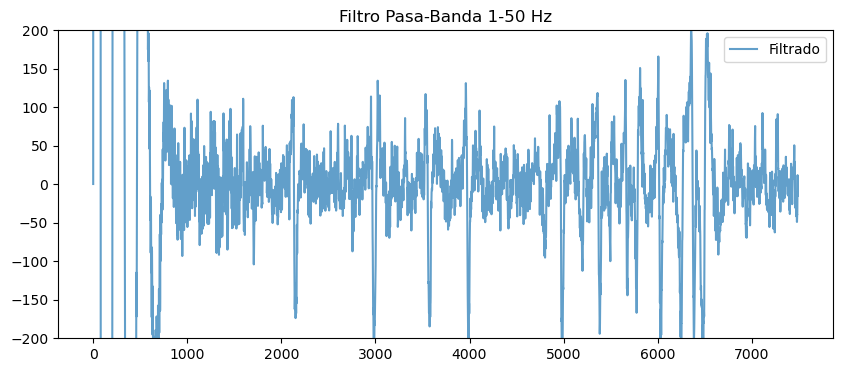

In [58]:
from scipy.signal import butter, filtfilt
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs 
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y
fs = 256  
lowcut = 1
highcut = 50

canal_filtrado = butter_bandpass_filter(fp1 , lowcut, highcut, fs)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(canal_filtrado, label='Filtered', alpha=0.7)
plt.ylim(-200, 200) 
plt.legend()
plt.title("Filter Band-Pass 1-50 Hz")
plt.show()

In [26]:
### Infor about device

print(BoardShim.get_board_descr(BoardIds.CYTON_BOARD))

{'accel_channels': [9, 10, 11], 'analog_channels': [19, 20, 21], 'ecg_channels': [1, 2, 3, 4, 5, 6, 7, 8], 'eeg_channels': [1, 2, 3, 4, 5, 6, 7, 8], 'eeg_names': 'Fp1,Fp2,C3,C4,P7,P8,O1,O2', 'emg_channels': [1, 2, 3, 4, 5, 6, 7, 8], 'eog_channels': [1, 2, 3, 4, 5, 6, 7, 8], 'marker_channel': 23, 'name': 'Cyton', 'num_rows': 24, 'other_channels': [12, 13, 14, 15, 16, 17, 18], 'package_num_channel': 0, 'sampling_rate': 250, 'timestamp_channel': 22}
